# 1D Inhomogenious Heat Equation solution with FEM: 
# $$ \frac{\partial u(x,t)}{\partial t}- \frac{\partial}{\partial x}\left(k(x)\frac{\partial u(x,t)}{\partial x}\right)=f(x)$$

## $$ \text{First B.C.}\begin{cases} \frac{\partial u(x,t)}{\partial x}\Big|_a=0 \quad, \quad \frac{\partial u(x,t)}{\partial x}\Big|_b=0 \end{cases}$$

## $$\text{Second B.C.}\begin{cases}  \frac{\partial u(x,t)}{\partial x}\Big|_{a}=\frac{\partial u(x,t)}{\partial x}\Big|_{b} \quad, \quad \frac{u(b)-u(a)}{b-a} = \frac{\partial u(x,t)}{\partial x}\Big|_{b} \end{cases}$$

## $$\text{I.C.}\begin{cases} u(x,0)=u_{0}(x), \ \ x \in [a,b] \end{cases}$$


Description of the programm...

### This is a General part for all programs

In [1]:
import numpy as np # to manupulate Matrices and solve Linear Systems
from scipy.integrate import quad # to integrate numericaly
import matplotlib.pyplot as plt # Plot the Numerical and Analitic solution to the Differential Equation
from matplotlib import animation # Library to make animations(make sure you have ffmpeg installed in linux )
from scipy.integrate import odeint # Solve system of differential equations
from numba import jit
import time
import io
import base64
from IPython.display import HTML

In [2]:
class Element:
    """This class contains all the relevant atributes of the Triangulation Element in 1D """
    
    def __init__(self,index,Tinterval,N):
        
        self.index = index #Index of the element, it can be a number between 1 to N
        a = Tinterval[0] # left endpoint of interval (a,b)
        b = Tinterval[1] # right endpoint of interval (a,b)
        self.interval = [float(a)+float(index-1)*(float(b-a)/float(N)),float(a)+float(index)*(float(b-a)/float(N))] # interval of the Element
        self.length = self.interval[1]-self.interval[0] # Length of the element, for a uniform grid (this case) its equal for all, other grids (not always = lenght for all)
        self.dphi_i = -1./self.length # derivative of \phi_i 
        self.dphi_ii = 1./self.length # derivative of \phi_i+1
        self.enum = [index,index+1] # setting up the enumeration of the Elements
    
    def phi_i(self,x):
        # Correspondent phi_i function to the given element
        return (self.interval[1]-x)/(self.length)
    
    def phi_ii(self,x):
        # Correspondent phi_i+1 function to the given element
        return (x-self.interval[0])/(self.length)
    
    def setlocalMatrixSpace(self,a11,a12,a21,a22):
        # this function sets up the local matrix A (matrix for spatial derivative) corresponding to the element
        self.localMatrixSpace = np.array([[a11,a12],[a21,a22]])
        
    def setlocalMatrixTime(self,m11,m12,m21,m22):
        # this function sets up the local matrix M (matrix for time derivative) corresponding to the element
        self.localMatrixTime = np.array([[m11,m12],[m21,m22]])
    
    def setlocalside(self,b1,b2):
        # this function sets up the local side corresponding to the element
        self.localside = np.array([b1,b2])

## 1. Solution of the problem with $k(x)=1$, $ f(x)=0$ and $u_{0}(x)=x$  with  $x \in [0,10]$: 
# $$ \frac{\partial u(x,t)}{\partial t}- \frac{\partial^2 u(x,t)}{\partial x^2}=0$$

## $$ \text{Frist B.C.}\begin{cases} \frac{\partial u(x,t)}{\partial x}\Big|_{0}=0 \quad, \quad \frac{\partial u(x,t)}{\partial x}\Big|_{10}=0 \end{cases}$$

## $$\text{Second B.C.}\begin{cases}  \frac{\partial u(x,t)}{\partial x}\Big|_{0}=\frac{\partial u(x,t)}{\partial x}\Big|_{10} \quad, \quad \frac{u(10)-u(0)}{10} = \frac{\partial u(x,t)}{\partial x}\Big|_{10} \end{cases}$$


## $$\text{I.C.}\begin{cases} \text{Different initial conditions} \end{cases}$$

In [3]:
def setProblem():
    """Setting up of the Problem parameters"""
    interval = [0.,10.]
    return interval,lambda x: 0., lambda x: 1

In [4]:
# Setting problem up and making of all  elements
interval,f,k = setProblem() # initialising the interval of solution and functions f(x) and k(x)
partitions = 5000 # number of partitions in the 1D Solution Grid
listElements = [] # All elements(objects) of the Grid are stored in this list for convenience
for i in xrange(partitions): # Set the atributes for all elements, each corresponing to an interval
    Elementi = Element(i+1,interval,partitions)
    listElements.append(Elementi)

In [5]:
# Setting up the all local matrices

for e in listElements:#The matrix elements a_ij, m_ij  and the side b_i are computed with the galerkin method results
    #Assembly of local matrices a_ij (matrix for spatial derivative)
    a11 = quad(lambda x : e.dphi_i*e.dphi_i*k(x),e.interval[0],e.interval[1])#
    a12 = quad(lambda x : e.dphi_ii*e.dphi_i*k(x),e.interval[0],e.interval[1])
    a22 = quad(lambda x : e.dphi_ii*e.dphi_ii*k(x),e.interval[0],e.interval[1])
    e.setlocalMatrixSpace(a11[0],a12[0],a12[0],a22[0])
    #Assembly of local matrices m_ij (matrix for time derivative)
    m11 = quad(lambda x : e.phi_i(x)*e.phi_i(x),e.interval[0],e.interval[1])#
    m12 = quad(lambda x : e.phi_ii(x)*e.phi_i(x),e.interval[0],e.interval[1])
    m22 = quad(lambda x : e.phi_ii(x)*e.phi_ii(x),e.interval[0],e.interval[1])
    e.setlocalMatrixTime(m11[0],m12[0],m12[0],m22[0])
    #Assembly of local sides b_i
    b1 = quad(lambda x : f(x)*e.phi_i(x),e.interval[0],e.interval[1])
    b2 = quad(lambda x : f(x)*e.phi_ii(x),e.interval[0],e.interval[1])
    e.setlocalside(b1[0],b2[0])

In [6]:
# Setting up the Global matrices M, A and global side b

A = np.zeros((partitions+1,partitions+1))
M = np.zeros((partitions+1,partitions+1))
b = np.zeros((partitions+1,1))
for e in listElements:# Setting up the Global matrices and Global side using the contribution of each element
    #Assembly of Global matrix A (matrix for spatial derivative)
    A[e.index-1][e.index-1] +=e.localMatrixSpace[0][0]
    A[e.index-1][e.index] +=e.localMatrixSpace[0][1] 
    A[e.index][e.index-1] +=e.localMatrixSpace[1][0]  
    A[e.index][e.index] +=e.localMatrixSpace[1][1]
    #Assembly of Global matrix M (matrix for time derivative)
    M[e.index-1][e.index-1] +=e.localMatrixTime[0][0]
    M[e.index-1][e.index] +=e.localMatrixTime[0][1] 
    M[e.index][e.index-1] +=e.localMatrixTime[1][0]  
    M[e.index][e.index] +=e.localMatrixTime[1][1]  
    #Assembly of Global side b
    b[e.index-1] += e.localside[0]
    b[e.index] += e.localside[1]

print A.shape
print M.shape
print b.shape

(5001, 5001)
(5001, 5001)
(5001, 1)


### Setting up initial condition
### $$\text{I.C.}\begin{cases} u(x,0)=\frac{(partitions)}{10N}\sum_{i=1}^{N}\delta(x-b_i), \ \ x,b_i  \in [0,10] \end{cases}$$

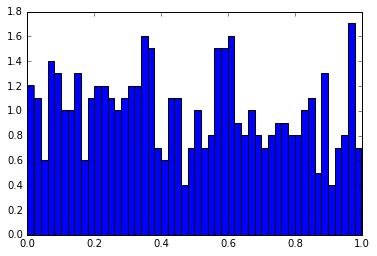

(500,)
(500,)
(500,)


In [7]:
mu, sigma = 5, 0.1 # parameters for a random Gaussian distribution
N=500 # Number of initial random points (deltas)

randarray = np.random.random([N]) # Generating a list of a uniform distribution in the interval [0,1]
randarray_pre = randarray # auxiliary array

#randarray_pre = np.random.normal(mu,sigma,N) # Generating a list of a gaussian distribution 
#randarray = np.array([j/10. for i,j in enumerate(randarray_pre)]) # relocate the distribution in the interval [0,1]

randarray1 = np.zeros(N) #auxiliary random array 1
randarray2 = np.zeros(N) #auxiliary random array 2
count, bins, ignored = plt.hist(randarray_pre, 50, normed=True) # Original histogram, the numbers lie on [0,1]
plt.show()
print randarray.shape
print randarray1.shape
print randarray2.shape

In [8]:
x = np.array([(1./float(partitions))*i for i in xrange(partitions+1)]) #  The interval [0,1] is divided in (#) partitions 
for j in xrange(len(randarray1)): # For a specific value of the initial random array we find the interval in X closest to the value 
    lmin = 1.
    for i,x_i in enumerate(x):  # Search for the closest value of X from a random point j 
        length = abs(randarray[j]-x_i)

        if (length < lmin):
            lmin = length
            randarray1[j] = x_i # Appending of the closest point to auxiliary array 1
            randarray2[j] = (i) # More general appending (only append the index of the closest point in x) this formulation allow us to extend this sorting to any interval [a,b]
print randarray1.shape
print randarray2.shape

(500,)
(500,)


[ 0.  0.  0. ...,  0.  0.  0.]
0.082361796931
0.4770836


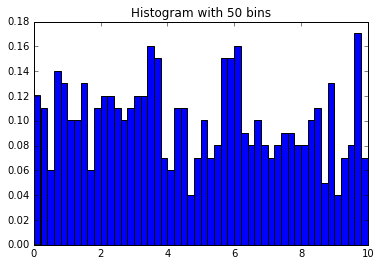

In [9]:
randarray3 = np.zeros(partitions+1) # Creation of array of coefitients of initial conditions.
for i,r2_i in enumerate(randarray2): # For any interval [a,b] partitioned (#) , a normalized weight is added in a slot of the array every time that a pint in the initla [0,1] random array was in a particular interval of x [1/partition*1, 1/partition *(i+1)]
    randarray3[int(r2_i)]+=float(partitions)/(float(N)*float(abs(interval[1]-interval[0])))
print randarray3

plt.hist(randarray1*10,bins=50,color='b',normed = 1)  # New histogram(the structure is maintained) , the numbers lie on [0,10]
plt.title("Histogram with 50 bins")
plt.show()

### 1.1  Solving system using Neumman boundary conditions $ \frac{\partial u(x,t)}{\partial x}\Big|_{0}=0 \quad, \quad \frac{\partial u(x,t)}{\partial x}\Big|_{10}=0$

In [17]:
# setting up the Neumman boundary conditions
b_n = np.copy(b) # Creating new boundary side b (The side is not overwriten in order to use more boundary conditions)
A_n = np.copy(A) # Creating new boundary Matrix A (The matrix is not overwriten in order to use more boundary conditions) 
b_n[0]+=0.# boundary condition u_x(0)=0
b_n[-1]+=0.# boundary condition u_x(10)=0
print b_n.shape

(5001, 1)


In [116]:
#Solving the linear ODE system with Neumman transformed system(implicit euler)
#start = time.time()
steps = 1001. # Length of the number of time step solutions  (# of steps in the euler method)
total_t = 0.1 # Total evolution time of the solution
delta_t = total_t/steps # \Delta t from the implicit euler method
A_net = ((1/delta_t)*M)+A_n # Net A matrix for system Ax=b from the galerkin method result, note that we use the A_n and b_n from the boundary condition 
x_i = randarray3 # We define the initial solution x_i for the euler methd algorithm
print x_i
sol = np.zeros([int(steps),partitions+1]) # Creating solution array with each row as the  \Delta t time solution
print sol.shape
sol[0][:] = np.squeeze(x_i) # Appending the initial condition
print sol[0][:]
for i in xrange(int(steps)-2):
    b_net = b_n+(1/delta_t)*np.transpose([M.dot(np.squeeze(x_i))]) # Net b matrix for system Ax=b from the galerkin method result, note that we use the A_n and b_n from the boundary condition 
    x_ii = np.linalg.solve(A_net,np.squeeze(b_net)) # We find new solution for system A_net x=b_net
    sol[i+1][:] = x_ii # Appending the initial condition for current time step
    x_i = np.array([x_ii]) # Redefining the initial condition in order to iterate with the euler algorithm
    if i % 100 == 0 : print i # Marker in order to check when does the iteration finish, (it takes long time in python)
print sol.shape
#end = time.time() 
#print end - start

[ 0.  0.  0. ...,  0.  0.  0.]
(1001, 5001)
[ 0.  0.  0. ...,  0.  0.  0.]
0
100
200
300
400
500
600
700
800
900
(1001, 5001)


In [98]:
# Checking the conservation of the mass and the conservation of the mean 

mass_t_n = [] # Creation of an array of the mass at each timestep
mean_t_n = [] # Creation of an array of the mean at each timestep

for i,item in enumerate(sol): # iteration in the solution array, the item is the solution at each timestep
    if i == sol.shape[0]-1: # conditional in order to stop the index i of going out of bounds
        break
    mass_e = [] # mass of a local element e
    mean_e = [] # mean of a local element e
    for j,e in enumerate(listElements) : # Calculating the mean and mass given the contributions for the element from phi_i and Phi_i+1
        mass_e.append(quad(lambda x : item[e.index-1]*e.phi_i(x)+item[e.index]*e.phi_ii(x),e.interval[0],e.interval[1]))
        mean_e.append(quad(lambda x : x*(item[e.index-1]*e.phi_i(x)+item[e.index]*e.phi_ii(x)),e.interval[0],e.interval[1]))
    
    mass_t_n.append(np.sum(mass_e)) # calculation of the mass of the solution at timestep i
    mean_t_n.append(np.sum(mean_e)) # calculation of the mean of the solution at timestep i

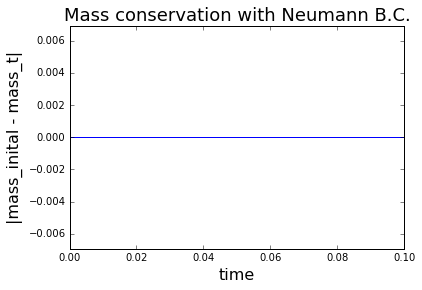

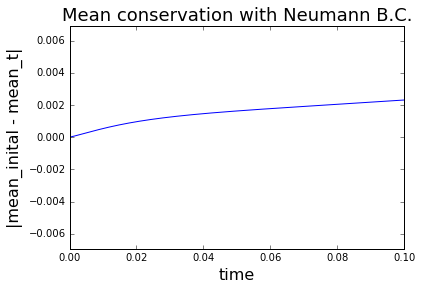

In [99]:
#Plot of the variation of the mass and the mean over time
delta_mass_n = [abs(mass_t_n[0] - item) for i,item in enumerate(mass_t_n)] # We compare the mass of the first element with all the other
delta_mean_n = [abs(mean_t_n[0] - item) for i,item in enumerate(mean_t_n)] # We compare the mean of the first element with all the other
t = np.linspace(0,total_t,len(mass_t_n))

plt.axes(xlim=(0, total_t),ylim=(-delta_mean_n[-1]*3, delta_mean_n[-1]*3))
plt.ylabel('|mass_inital - mass_t|',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.title("Mass conservation with Neumann B.C.",fontsize=18)
plt.plot(t,delta_mass_n) # if mass is conserved the plot should be zero
plt.show()

plt.axes(xlim=(0, total_t),ylim=(-delta_mean_n[-1]*3, delta_mean_n[-1]*3))
plt.ylabel('|mean_inital - mean_t|',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.title("Mean conservation with Neumann B.C.",fontsize=18)
plt.plot(t,delta_mean_n) # if mean is conserved the plot should be zero
plt.show()

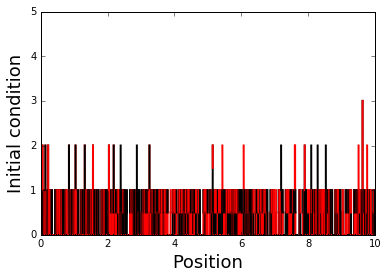

In [84]:
#Plot of the initial conditon
color = ['k','r'] #Colors of the approximate solution graph
c = []
plt.axes(xlim=(0, 10), ylim=(0, 5))
for i in xrange(partitions): #Alternating the two colors in color list
    if (i%2==0):
        c.append(color[0])
    else :
        c.append(color[1])
x = randarray3
for e in listElements : # Plotting the intial condition given the contributions for the element from phi_i and Phi_i+1
    y = np.arange(e.interval[0],e.interval[1],0.001)
    plt.plot(y,x[e.index-1]*e.phi_i(y)+x[e.index]*e.phi_ii(y), c[e.index-1], linewidth=2.0)
y_1 = np.arange(interval[0],interval[1],0.001)
#plt.plot(y_1,y_1, 'b')
plt.ylabel('Initial condition',fontsize=18)
plt.xlabel('Position',fontsize=18)
plt.show()

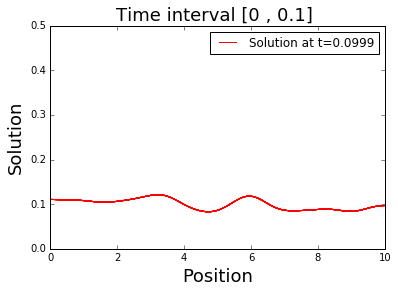

In [100]:
#Animation of the Numerical solution 

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 10), ylim=(0, 0.5))
N1 = partitions # partitions elements of the approximate solution
lines = [plt.plot([], [])[0] for _ in range(N1)] # number of lines to animate
Nframes = 1000 # numbers of frames you want to animate  

#plt.hist(randarray1*10,bins=25, color='b',normed = True)  # histogram for comparison (only useful with small data)

plt.ylabel('Solution',fontsize=18)
plt.xlabel('Position',fontsize=18)
plt.title("Time interval [0 , %s] "%total_t,fontsize=18)

# initialization function: plot the background of each frame
def init():
    for line in lines: # We iterate in all the lines we want to plot and animate
        line.set_data([], [])
        line.set_color('red') # al lines colors are set to red
    return lines

# animation function.  This is called sequentially
def animate(i):
    local_i = (i*(total_t/Nframes))
    plt.legend(["Solution at t=%s"%local_i], loc=1)
    for j,line in enumerate(lines): # We iterate in all the lines we want to plot and animate

        e=listElements[j] # for each line we consider its element atributes in order to animate it
        x = np.arange(e.interval[0],e.interval[1],0.001)
        y = sol[i][e.index-1]*e.phi_i(x)+sol[i][e.index]*e.phi_ii(x) 
        line.set_data(x, y)
            
    return lines

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=Nframes, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html

anim.save('neumann_boundary.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.show()

In [2]:
video = io.open('neumann_boundary.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

### 1.2  Solving system using Mean conservation boundary conditions

$$ \frac{\partial u(x,t)}{\partial x}\Big|_{0}=\frac{\partial u(x,t)}{\partial x}\Big|_{10} \quad, \quad \frac{u(10)-u(0)}{10} = \frac{\partial u(x,t)}{\partial x}\Big|_{10}$$

In [103]:
# setting up the Mean conservation boundary conditions
b_m = np.copy(b) # Creating new boundary side b (The side is not overwriten in order to use more boundary conditions)
A_m = np.copy(A) # Creating new boundary Matrix A(The Matrix A is not overwriten in order to use more boundary conditions) 
A_m[0][0] += -1./(interval[1]-interval[0]) # first vertex boundary condition 
A_m[0][-1] += 1./(interval[1]-interval[0])# second vertex boundary condition 
A_m[-1][0] += 1./(interval[1]-interval[0])# third vertex boundary condition 
A_m[-1][-1] += -1./(interval[1]-interval[0])# fourth vertex boundary condition 
print A_m.shape

(5001, 5001)


In [104]:
#Solving the linear ODE system with Mean Conservation transformed system(implicit euler)
#start = time.time()
steps = 1001. # Length of the number of time step solutions  (# of steps in the euler method)
total_t = 0.1 # Total evolution time of the solution
delta_t = total_t/steps # \Delta t from the implicit euler method
A_net = ((1/delta_t)*M)+A_m # Net A matrix for system Ax=b from the galerkin method result, note that we use the A_n and b_n from the boundary condition 
x_i = randarray3 # We define the initial solution x_i for the euler methd algorithm
print x_i
sol = np.zeros([int(steps),partitions+1]) # Creating solution array with each row as the  \Delta t time solution
print sol.shape
sol[0][:] = np.squeeze(x_i) # Appending the initial condition
print sol[0][:]
for i in xrange(int(steps)-2):
    b_net = b_m+(1/delta_t)*np.transpose([M.dot(np.squeeze(x_i))]) # Net b matrix for system Ax=b from the galerkin method result, note that we use the A_n and b_n from the boundary condition 
    x_ii = np.linalg.solve(A_net,np.squeeze(b_net)) # We find new solution for system A_net x=b_net
    sol[i+1][:] = x_ii # Appending the initial condition for current time step
    x_i = np.array([x_ii]) # Redefining the initial condition in order to iterate with the euler algorithm
    if i % 100 == 0 : print i # Marker in order to check when does the iteration finish, (it takes long time in python)
print sol.shape
#end = time.time() 
#print end - start

[ 0.  0.  0. ...,  0.  0.  0.]
(1001, 5001)
[ 0.  0.  0. ...,  0.  0.  0.]
0
100
200
300
400
500
600
700
800
900
(1001, 5001)


In [105]:
# Checking the conservation of the mass and the conservation of the mean 

mass_t_m = [] # Creation of an array of the mass at each timestep
mean_t_m = [] # Creation of an array of the mean at each timestep

for i,item in enumerate(sol): # iteration in the solution array, the item is the solution at each timestep
    if i == sol.shape[0]-1: # conditional in order to stop the index i of going out of bounds
        break
    mass_e = [] # mass of a local element e
    mean_e = [] # mean of a local element e
    for j,e in enumerate(listElements) : # Calculating the mean and mass given the contributions for the element from phi_i and Phi_i+1
        mass_e.append(quad(lambda x : item[e.index-1]*e.phi_i(x)+item[e.index]*e.phi_ii(x),e.interval[0],e.interval[1]))
        mean_e.append(quad(lambda x : x*(item[e.index-1]*e.phi_i(x)+item[e.index]*e.phi_ii(x)),e.interval[0],e.interval[1]))
    
    mass_t_m.append(np.sum(mass_e)) # calculation of the mass of the solution at timestep i
    mean_t_m.append(np.sum(mean_e)) # calculation of the mean of the solution at timestep i

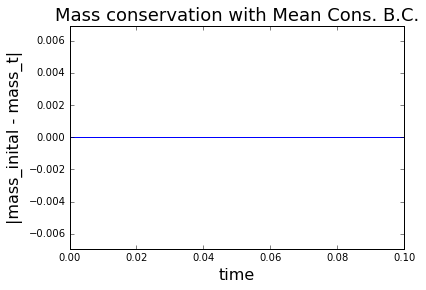

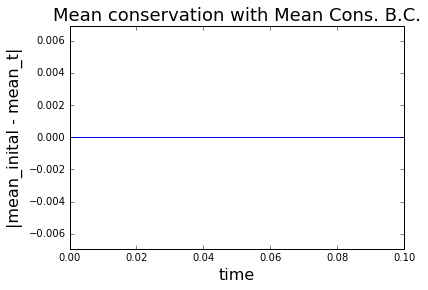

In [106]:
#Plot of the variation of the mass and the mean over time
delta_mass_m = [abs(mass_t_m[0] - item) for i,item in enumerate(mass_t_m)] # We compare the mass of the first element with all the other
delta_mean_m = [abs(mean_t_m[0] - item) for i,item in enumerate(mean_t_m)] # We compare the mean of the first element with all the other
t = np.linspace(0,total_t,len(mass_t_n))

plt.axes(xlim=(0, total_t),ylim=(-delta_mean_n[-1]*3, delta_mean_n[-1]*3))
plt.ylabel('|mass_inital - mass_t|',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.title("Mass conservation with Mean Cons. B.C.",fontsize=18)
plt.plot(t,delta_mass_m) # if mass is conserved the plot should be zero
plt.show()

plt.axes(xlim=(0, total_t),ylim=(-delta_mean_n[-1]*3, delta_mean_n[-1]*3))
plt.ylabel('|mean_inital - mean_t|',fontsize=16)
plt.xlabel('time',fontsize=16)
plt.title("Mean conservation with Mean Cons. B.C.",fontsize=18)
plt.plot(t,delta_mean_m) # if mean is conserved the plot should be zero
plt.show()

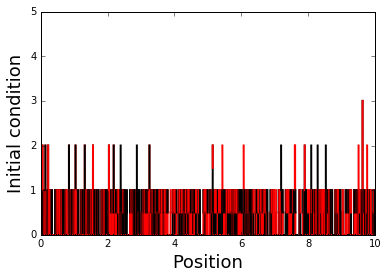

In [107]:
#Plot of the initial conditon
color = ['k','r'] #Colors of the approximate solution graph
c = []
plt.axes(xlim=(0, 10), ylim=(0, 5))
for i in xrange(partitions): #Alternating the two colors in color list
    if (i%2==0):
        c.append(color[0])
    else :
        c.append(color[1])
x = randarray3
for e in listElements : # Plotting the intial condition given the contributions for the element from phi_i and Phi_i+1
    y = np.arange(e.interval[0],e.interval[1],0.001)
    plt.plot(y,x[e.index-1]*e.phi_i(y)+x[e.index]*e.phi_ii(y), c[e.index-1], linewidth=2.0)
y_1 = np.arange(interval[0],interval[1],0.001)
#plt.plot(y_1,y_1, 'b')
plt.ylabel('Initial condition',fontsize=18)
plt.xlabel('Position',fontsize=18)
plt.show()

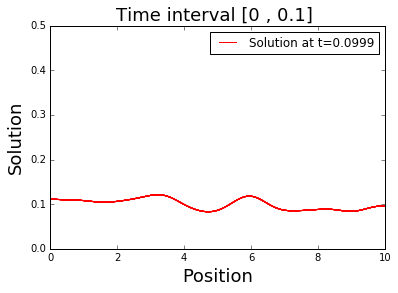

In [108]:
#Animation of the Numerical solution 

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 10), ylim=(0, 0.5))
N1 = partitions # partitions elements of the approximate solution
lines = [plt.plot([], [])[0] for _ in range(N1)] # number of lines to animate
Nframes = 1000 # numbers of frames you want to animate  

#plt.hist(randarray1*10,bins=25, color='b',normed = True)  # histogram for comparison (only useful with small data)

plt.ylabel('Solution',fontsize=18)
plt.xlabel('Position',fontsize=18)
plt.title("Time interval [0 , %s] "%total_t,fontsize=18)

# initialization function: plot the background of each frame
def init():
    for line in lines: # We iterate in all the lines we want to plot and animate
        line.set_data([], [])
        line.set_color('red') # al lines colors are set to red
    return lines

# animation function.  This is called sequentially
def animate(i):
    local_i = (i*(total_t/Nframes))
    plt.legend(["Solution at t=%s"%local_i], loc=1)
    for j,line in enumerate(lines): # We iterate in all the lines we want to plot and animate

        e=listElements[j] # for each line we consider its element atributes in order to animate it
        x = np.arange(e.interval[0],e.interval[1],0.001)
        y = sol[i][e.index-1]*e.phi_i(x)+sol[i][e.index]*e.phi_ii(x) 
        line.set_data(x, y)
            
    return lines

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=Nframes, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html

anim.save('mean_boundary.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.show()

In [3]:
video = io.open('mean_boundary.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))